<a href="https://colab.research.google.com/github/Magferat/Clustering-with-Neural-Networks/blob/main/DEC_CSE425.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
import pandas as pd

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.66MB/s]


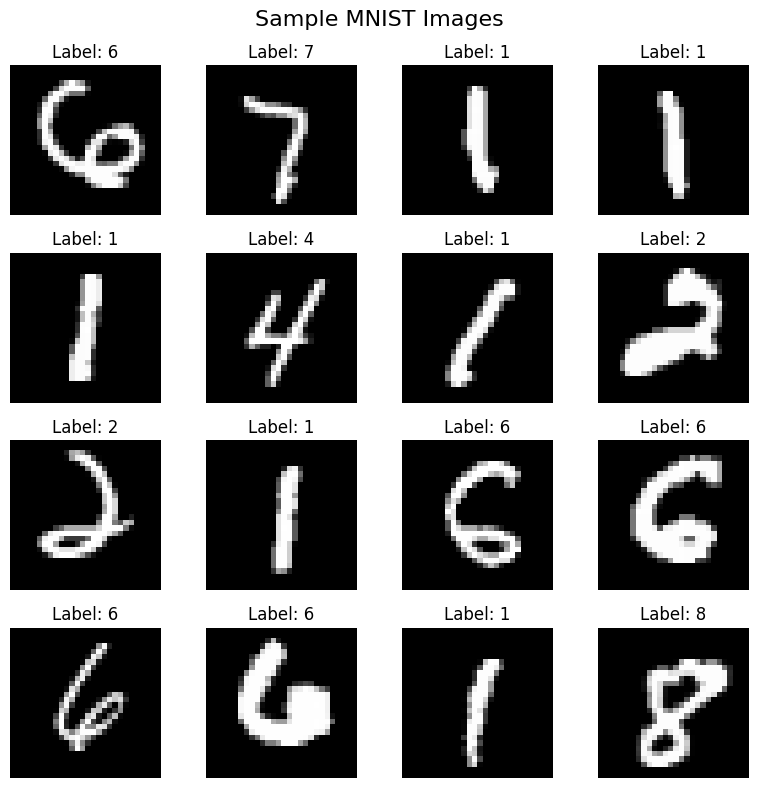

In [3]:


# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the first 16 images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Sample MNIST Images", fontsize=16)
plt.tight_layout()
plt.show()


<ipython-input-4-e5b6255af81d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Digit", data=label_df, palette="viridis")


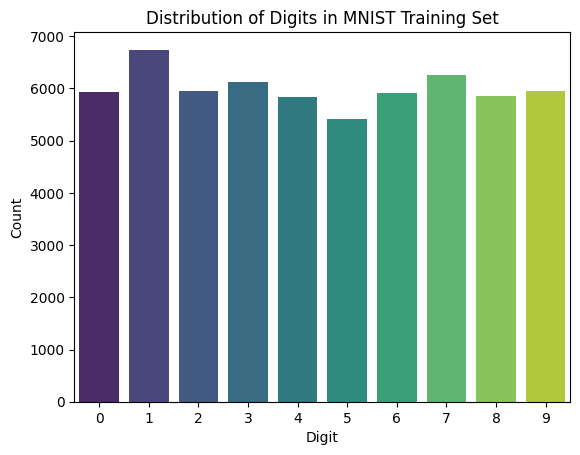

In [4]:


# Collect all labels from the full dataset
all_labels = [label for _, label in train_dataset]

# Create a bar plot of label distribution
label_df = pd.DataFrame(all_labels, columns=["Digit"])
sns.countplot(x="Digit", data=label_df, palette="viridis")
plt.title("Distribution of Digits in MNIST Training Set")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # 28x28
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon


In [6]:
ae = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

# Pretrain loop
for epoch in range(30):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"AE Epoch {epoch+1}"):
        imgs = imgs.to(device)
        _, recons = ae(imgs)
        loss = criterion(recons, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


AE Epoch 1: 100%|██████████| 235/235 [00:14<00:00, 16.20it/s]


Epoch 1, Loss: 0.3564


AE Epoch 2: 100%|██████████| 235/235 [00:13<00:00, 17.81it/s]


Epoch 2, Loss: 0.1165


AE Epoch 3: 100%|██████████| 235/235 [00:14<00:00, 15.93it/s]


Epoch 3, Loss: 0.0919


AE Epoch 4: 100%|██████████| 235/235 [00:13<00:00, 17.71it/s]


Epoch 4, Loss: 0.0826


AE Epoch 5: 100%|██████████| 235/235 [00:12<00:00, 18.28it/s]


Epoch 5, Loss: 0.0772


AE Epoch 6: 100%|██████████| 235/235 [00:13<00:00, 17.79it/s]


Epoch 6, Loss: 0.0733


AE Epoch 7: 100%|██████████| 235/235 [00:12<00:00, 18.12it/s]


Epoch 7, Loss: 0.0706


AE Epoch 8: 100%|██████████| 235/235 [00:13<00:00, 17.71it/s]


Epoch 8, Loss: 0.0684


AE Epoch 9: 100%|██████████| 235/235 [00:13<00:00, 18.00it/s]


Epoch 9, Loss: 0.0666


AE Epoch 10: 100%|██████████| 235/235 [00:13<00:00, 17.95it/s]


Epoch 10, Loss: 0.0650


AE Epoch 11: 100%|██████████| 235/235 [00:12<00:00, 18.16it/s]


Epoch 11, Loss: 0.0637


AE Epoch 12: 100%|██████████| 235/235 [00:12<00:00, 18.23it/s]


Epoch 12, Loss: 0.0624


AE Epoch 13: 100%|██████████| 235/235 [00:13<00:00, 17.85it/s]


Epoch 13, Loss: 0.0614


AE Epoch 14: 100%|██████████| 235/235 [00:12<00:00, 18.21it/s]


Epoch 14, Loss: 0.0606


AE Epoch 15: 100%|██████████| 235/235 [00:12<00:00, 18.37it/s]


Epoch 15, Loss: 0.0598


AE Epoch 16: 100%|██████████| 235/235 [00:12<00:00, 18.16it/s]


Epoch 16, Loss: 0.0590


AE Epoch 17: 100%|██████████| 235/235 [00:12<00:00, 18.64it/s]


Epoch 17, Loss: 0.0583


AE Epoch 18: 100%|██████████| 235/235 [00:12<00:00, 18.35it/s]


Epoch 18, Loss: 0.0577


AE Epoch 19: 100%|██████████| 235/235 [00:12<00:00, 18.49it/s]


Epoch 19, Loss: 0.0571


AE Epoch 20: 100%|██████████| 235/235 [00:12<00:00, 18.56it/s]


Epoch 20, Loss: 0.0566


AE Epoch 21: 100%|██████████| 235/235 [00:12<00:00, 18.24it/s]


Epoch 21, Loss: 0.0562


AE Epoch 22: 100%|██████████| 235/235 [00:12<00:00, 18.22it/s]


Epoch 22, Loss: 0.0557


AE Epoch 23: 100%|██████████| 235/235 [00:12<00:00, 18.10it/s]


Epoch 23, Loss: 0.0553


AE Epoch 24: 100%|██████████| 235/235 [00:12<00:00, 18.36it/s]


Epoch 24, Loss: 0.0548


AE Epoch 25: 100%|██████████| 235/235 [00:12<00:00, 18.51it/s]


Epoch 25, Loss: 0.0545


AE Epoch 26: 100%|██████████| 235/235 [00:12<00:00, 18.57it/s]


Epoch 26, Loss: 0.0542


AE Epoch 27: 100%|██████████| 235/235 [00:13<00:00, 18.00it/s]


Epoch 27, Loss: 0.0539


AE Epoch 28: 100%|██████████| 235/235 [00:12<00:00, 18.78it/s]


Epoch 28, Loss: 0.0536


AE Epoch 29: 100%|██████████| 235/235 [00:12<00:00, 18.81it/s]


Epoch 29, Loss: 0.0533


AE Epoch 30: 100%|██████████| 235/235 [00:12<00:00, 18.85it/s]

Epoch 30, Loss: 0.0530


In [7]:
def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

class DEC:
    def __init__(self, model, n_clusters=10, alpha=1.0):
        self.model = model
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(
            torch.randn(n_clusters, 10, dtype=torch.float32).to(device)
        )

    def soft_assign(self, z):
        z = z.float()
        dist = torch.cdist(z, self.cluster_centers, p=2) ** 2
        num = (1.0 + dist / self.alpha) ** ((self.alpha + 1.0) / -2)
        return (num.T / num.sum(1)).T  # shape: (batch, n_clusters)

    def kl_loss(self, q, p):
        return torch.nn.functional.kl_div(q.log(), p, reduction='batchmean')

# Step 1: Extract embeddings
ae.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        all_embeddings.append(z.cpu())
        all_labels.append(labels)

embeddings = torch.cat(all_embeddings)
labels = torch.cat(all_labels)

# Step 2: Init cluster centers with KMeans
kmeans = KMeans(n_clusters=10, n_init=20)
y_pred = kmeans.fit_predict(embeddings)
dec = DEC(ae, 10)
dec.cluster_centers.data = torch.tensor(
    kmeans.cluster_centers_, dtype=torch.float32, device=device
)

# Step 3: DEC training
optimizer = optim.Adam(
    [{'params': ae.encoder.parameters()}, {'params': dec.cluster_centers}], lr=1e-3
)

for epoch in range(40):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"DEC Epoch {epoch+1}"):
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        q = dec.soft_assign(z)
        p = target_distribution(q.detach())
        loss = dec.kl_loss(q, p)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[DEC] Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


DEC Epoch 1: 100%|██████████| 235/235 [00:12<00:00, 18.69it/s]


[DEC] Epoch 1, Loss: 0.2209


DEC Epoch 2: 100%|██████████| 235/235 [00:12<00:00, 19.20it/s]


[DEC] Epoch 2, Loss: 0.1960


DEC Epoch 3: 100%|██████████| 235/235 [00:12<00:00, 19.09it/s]


[DEC] Epoch 3, Loss: 0.1840


DEC Epoch 4: 100%|██████████| 235/235 [00:12<00:00, 19.08it/s]


[DEC] Epoch 4, Loss: 0.1760


DEC Epoch 5: 100%|██████████| 235/235 [00:12<00:00, 19.33it/s]


[DEC] Epoch 5, Loss: 0.1698


DEC Epoch 6: 100%|██████████| 235/235 [00:12<00:00, 19.58it/s]


[DEC] Epoch 6, Loss: 0.1650


DEC Epoch 7: 100%|██████████| 235/235 [00:12<00:00, 19.43it/s]


[DEC] Epoch 7, Loss: 0.1608


DEC Epoch 8: 100%|██████████| 235/235 [00:12<00:00, 19.56it/s]


[DEC] Epoch 8, Loss: 0.1566


DEC Epoch 9: 100%|██████████| 235/235 [00:12<00:00, 18.95it/s]


[DEC] Epoch 9, Loss: 0.1533


DEC Epoch 10: 100%|██████████| 235/235 [00:12<00:00, 18.95it/s]


[DEC] Epoch 10, Loss: 0.1500


DEC Epoch 11: 100%|██████████| 235/235 [00:12<00:00, 19.30it/s]


[DEC] Epoch 11, Loss: 0.1472


DEC Epoch 12: 100%|██████████| 235/235 [00:12<00:00, 19.03it/s]


[DEC] Epoch 12, Loss: 0.1446


DEC Epoch 13: 100%|██████████| 235/235 [00:12<00:00, 18.42it/s]


[DEC] Epoch 13, Loss: 0.1421


DEC Epoch 14: 100%|██████████| 235/235 [00:12<00:00, 18.95it/s]


[DEC] Epoch 14, Loss: 0.1403


DEC Epoch 15: 100%|██████████| 235/235 [00:12<00:00, 18.93it/s]


[DEC] Epoch 15, Loss: 0.1381


DEC Epoch 16: 100%|██████████| 235/235 [00:12<00:00, 19.17it/s]


[DEC] Epoch 16, Loss: 0.1367


DEC Epoch 17: 100%|██████████| 235/235 [00:12<00:00, 19.23it/s]


[DEC] Epoch 17, Loss: 0.1345


DEC Epoch 18: 100%|██████████| 235/235 [00:12<00:00, 19.27it/s]


[DEC] Epoch 18, Loss: 0.1326


DEC Epoch 19: 100%|██████████| 235/235 [00:12<00:00, 19.52it/s]


[DEC] Epoch 19, Loss: 0.1313


DEC Epoch 20: 100%|██████████| 235/235 [00:12<00:00, 19.29it/s]


[DEC] Epoch 20, Loss: 0.1296


DEC Epoch 21: 100%|██████████| 235/235 [00:12<00:00, 18.86it/s]


[DEC] Epoch 21, Loss: 0.1285


DEC Epoch 22: 100%|██████████| 235/235 [00:12<00:00, 19.35it/s]


[DEC] Epoch 22, Loss: 0.1270


DEC Epoch 23: 100%|██████████| 235/235 [00:12<00:00, 19.10it/s]


[DEC] Epoch 23, Loss: 0.1258


DEC Epoch 24: 100%|██████████| 235/235 [00:12<00:00, 19.17it/s]


[DEC] Epoch 24, Loss: 0.1245


DEC Epoch 25: 100%|██████████| 235/235 [00:12<00:00, 19.25it/s]


[DEC] Epoch 25, Loss: 0.1233


DEC Epoch 26: 100%|██████████| 235/235 [00:12<00:00, 19.00it/s]


[DEC] Epoch 26, Loss: 0.1223


DEC Epoch 27: 100%|██████████| 235/235 [00:12<00:00, 19.17it/s]


[DEC] Epoch 27, Loss: 0.1212


DEC Epoch 28: 100%|██████████| 235/235 [00:12<00:00, 19.35it/s]


[DEC] Epoch 28, Loss: 0.1205


DEC Epoch 29: 100%|██████████| 235/235 [00:12<00:00, 19.27it/s]


[DEC] Epoch 29, Loss: 0.1193


DEC Epoch 30: 100%|██████████| 235/235 [00:12<00:00, 19.20it/s]


[DEC] Epoch 30, Loss: 0.1183


DEC Epoch 31: 100%|██████████| 235/235 [00:12<00:00, 19.49it/s]


[DEC] Epoch 31, Loss: 0.1171


DEC Epoch 32: 100%|██████████| 235/235 [00:12<00:00, 19.48it/s]


[DEC] Epoch 32, Loss: 0.1163


DEC Epoch 33: 100%|██████████| 235/235 [00:12<00:00, 19.56it/s]


[DEC] Epoch 33, Loss: 0.1152


DEC Epoch 34: 100%|██████████| 235/235 [00:11<00:00, 19.68it/s]


[DEC] Epoch 34, Loss: 0.1145


DEC Epoch 35: 100%|██████████| 235/235 [00:11<00:00, 19.71it/s]


[DEC] Epoch 35, Loss: 0.1135


DEC Epoch 36: 100%|██████████| 235/235 [00:12<00:00, 19.32it/s]


[DEC] Epoch 36, Loss: 0.1130


DEC Epoch 37: 100%|██████████| 235/235 [00:12<00:00, 19.47it/s]


[DEC] Epoch 37, Loss: 0.1121


DEC Epoch 38: 100%|██████████| 235/235 [00:11<00:00, 19.61it/s]


[DEC] Epoch 38, Loss: 0.1111


DEC Epoch 39: 100%|██████████| 235/235 [00:11<00:00, 19.70it/s]


[DEC] Epoch 39, Loss: 0.1104


DEC Epoch 40: 100%|██████████| 235/235 [00:11<00:00, 19.68it/s]

[DEC] Epoch 40, Loss: 0.1097


In [8]:

ae.eval()
with torch.no_grad():
    all_z = []
    for imgs, _ in train_loader:
        z, _ = ae(imgs.to(device))
        all_z.append(z.cpu())
    z = torch.cat(all_z).numpy()

# KMeans clustering
kmeans = KMeans(n_clusters=10, n_init=20).fit(z)
labels_pred = kmeans.labels_

# Evaluation metrics
sil = silhouette_score(z, labels_pred)
db = davies_bouldin_score(z, labels_pred)
chi = calinski_harabasz_score(z, labels_pred)

print(f"Silhouette Score:         {sil:.4f}")
print(f"Davies-Bouldin Index:     {db:.4f}")
print(f"Calinski-Harabasz Index:  {chi:.4f}")


Silhouette Score:         0.7469
Davies-Bouldin Index:     0.3349
Calinski-Harabasz Index:  161922.6875


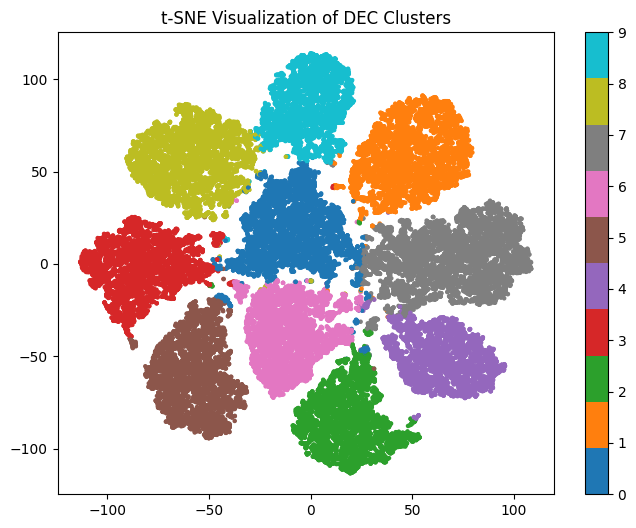

In [9]:
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z)

plt.figure(figsize=(8,6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=kmeans.labels_, cmap='tab10', s=5)
plt.title("t-SNE Visualization of DEC Clusters")
plt.colorbar()
plt.show()


In [10]:
import pickle

with open("dec_results.pkl", "wb") as f:
    pickle.dump({
        "embeddings": z,
        "labels": labels.numpy(),
        "preds": kmeans.labels_,
        "silhouette": sil,
        "db_score": db
    }, f)
torch.save(ae.state_dict(), "autoencoder_mnist.pth")
